In [32]:
import os
import operator
import functools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, DateType, IntegerType, StringType, DoubleType, BooleanType

In [33]:
spark = SparkSession.builder \
                .appName("flights") \
                .config("spark.executor.memory", "10G") \
                .config("spark.driver.memory", "2G") \
                .getOrCreate()

25/05/04 22:04:24 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [34]:
filepath = "./data/flights"
filenames = [ f"Combined_Flights_{y}.csv" for y in range(2018, 2023) ]

In [35]:
schema = StructType(
    [
        StructField("FlightDate", DateType(), True),
        StructField("Airline", StringType(), True),
        StructField("Origin", StringType(), True),
        StructField("Dest", StringType(), True),
        StructField("Cancelled", BooleanType(), True),
        StructField("Diverted", BooleanType(), True),
        StructField("CRSDepTime", IntegerType(), True),
        StructField("DepTime", DoubleType(), True),
        StructField("DepDelayMinutes", DoubleType(), True),
        StructField("DepDelay", DoubleType(), True),
        StructField("ArrTime", DoubleType(), True),
        StructField("ArrDelayMinutes", DoubleType(), True),
        StructField("AirTime", DoubleType(), True),
        StructField("CRSElapsedTime", DoubleType(), True),
        StructField("ActualElapsedTime", DoubleType(), True),
        StructField("Distance", DoubleType(), True),
        StructField("Year", IntegerType(), True),
        StructField("Quarter", IntegerType(), True),
        StructField("Month", IntegerType(), True),
        StructField("DayofMonth", IntegerType(), True),
        StructField("DayOfWeek", IntegerType(), True),
        StructField("Marketing_Airline_Network", StringType(), True),
        StructField("Operated_or_Branded_Code_Share_Partners", StringType(), True),
        StructField("DOT_ID_Marketing_Airline", StringType(), True),
        StructField("IATA_Code_Marketing_Airline", StringType(), True),
        StructField("Flight_Number_Marketing_Airline", StringType(), True),
        StructField("Operating_Airline", StringType(), True),
        StructField("DOT_ID_Operating_Airline", StringType(), True),
        StructField("IATA_Code_Operating_Airline", StringType(), True),
        StructField("Tail_Number", StringType(), True),
        StructField("Flight_Number_Operating_Airline", StringType(), True),
        StructField("OriginAirportID", StringType(), True),
        StructField("OriginAirportSeqID", StringType(), True),
        StructField("OriginCityMarketID", StringType(), True),
        StructField("OriginCityName", StringType(), True),
        StructField("OriginState", StringType(), True),
        StructField("OriginStateFips", StringType(), True),
        StructField("OriginStateName", StringType(), True),
        StructField("OriginWac", StringType(), True),
        StructField("DestAirportID", StringType(), True),
        StructField("DestAirportSeqID", StringType(), True),
        StructField("DestCityMarketID", StringType(), True),
        StructField("DestCityName", StringType(), True),
        StructField("DestState", StringType(), True),
        StructField("DestStateFips", StringType(), True),
        StructField("DestStateName", StringType(), True),
        StructField("DestWac", StringType(), True),
        StructField("DepDel15", StringType(), True),
        StructField("DepartureDelayGroups", StringType(), True),
        StructField("DepTimeBlk", StringType(), True),
        StructField("TaxiOut", DoubleType(), True),
        StructField("WheelsOff", DoubleType(), True),
        StructField("WheelsOn", DoubleType(), True),
        StructField("TaxiIn", DoubleType(), True),
        StructField("CRSArrTime", IntegerType(), True),
        StructField("ArrDelay", DoubleType(), True),
        StructField("ArrDel15", StringType(), True),
        StructField("ArrivalDelayGroups", StringType(), True),
        StructField("ArrTimeBlk", StringType(), True),
        StructField("DistanceGroup", StringType(), True),
        StructField("DivAirportLandings", StringType(), True),
    ]
)

In [36]:
df = spark.read.schema(schema).csv(f"{filepath}/{filenames[0]}", header=True)

In [37]:
cat_columns = ['Marketing_Airline_Network', 'Operating_Airline', 'Diverted', 'DayOfWeek', 'Month', 'DistanceGroup']

In [38]:
cat_stats = []

for column in cat_columns:
    stats = spark.read.parquet(f"{filepath}/{filenames[0][:-4]}_{column}", header=True)
    cat_stats.append(stats)
    print(column, stats.count())

Marketing_Airline_Network 11
Operating_Airline 28
Diverted 2
DayOfWeek 7
Month 12
DistanceGroup 11


In [39]:
result = cat_stats[0].withColumnRenamed('frecuencia', f'frecuencia_0').withColumnRenamed('frecuencia_relativa', f'frecuencia_relativa_0')
for i in range(1, len(cat_stats)):
    renamed = cat_stats[i].withColumnRenamed('frecuencia', f'frecuencia_{i}').withColumnRenamed('frecuencia_relativa', f'frecuencia_relativa_{i}')
    result = result.crossJoin(renamed)
result.show(10), result.count()

+-------------------------+------------+---------------------+-----------------+------------+---------------------+--------+------------+---------------------+---------+------------+---------------------+-----+------------+---------------------+-------------+------------+---------------------+
|Marketing_Airline_Network|frecuencia_0|frecuencia_relativa_0|Operating_Airline|frecuencia_1|frecuencia_relativa_1|Diverted|frecuencia_2|frecuencia_relativa_2|DayOfWeek|frecuencia_3|frecuencia_relativa_3|Month|frecuencia_4|frecuencia_relativa_4|DistanceGroup|frecuencia_5|frecuencia_relativa_5|
+-------------------------+------------+---------------------+-----------------+------------+---------------------+--------+------------+---------------------+---------+------------+---------------------+-----+------------+---------------------+-------------+------------+---------------------+
|                       UA|     1525263|               0.2681|               UA|      621565|               0.1092|

(None, 569184)

In [40]:
ocurrence_0_1 = result.withColumn('ocurrence', F.try_multiply(F.col('frecuencia_relativa_0'), F.col('frecuencia_relativa_1'))).select('Marketing_Airline_Network', 'Operating_Airline', 'ocurrence').distinct()
ocurrence_3_4 = result.withColumn('ocurrence', F.try_multiply(F.col('frecuencia_relativa_3'), F.col('frecuencia_relativa_4'))).select('DayOfWeek', 'Month', 'ocurrence').distinct()
ocurrence_0_5 = result.withColumn('ocurrence', F.try_multiply(F.col('frecuencia_relativa_0'), F.col('frecuencia_relativa_5'))).select('Marketing_Airline_Network', 'DistanceGroup', 'ocurrence').distinct()
ocurrence_0_2 = result.withColumn('ocurrence', F.try_multiply(F.col('frecuencia_relativa_0'), F.col('frecuencia_relativa_2'))).select('Marketing_Airline_Network', 'Diverted', 'ocurrence').distinct()
ocurrence_0_4 = result.withColumn('ocurrence', F.try_multiply(F.col('frecuencia_relativa_0'), F.col('frecuencia_relativa_4'))).select('Marketing_Airline_Network', 'Month', 'ocurrence').distinct()
ocurrence_0_3 = result.withColumn('ocurrence', F.try_multiply(F.col('frecuencia_relativa_0'), F.col('frecuencia_relativa_3'))).select('Marketing_Airline_Network', 'DayOfWeek', 'ocurrence').distinct()

Ocurrencia entre nombre comercial y nombre operativo de aerolineas

- 6% de ocurrencia que la linea area United Airlines sea el nombre comercial y Southwest Airlines el nombre operativo
- 5% de ocurrencia que Southwest Airline sea el mismo nombre comercial y operativo
- 3% de ocurrencia que la linea area American Airlines sea el nombre comercial y Southwest Airlines el nombre operativo

In [41]:
ocurrence_0_1.sort(F.desc('ocurrence')).show()

+-------------------------+-----------------+--------------------+
|Marketing_Airline_Network|Operating_Airline|           ocurrence|
+-------------------------+-----------------+--------------------+
|                       UA|               WN|          0.06372737|
|                       WN|               WN|0.056501289999999996|
|                       AA|               WN|0.035773849999999996|
|                       DL|               WN|          0.03503698|
|                       UA|               UA|          0.02927652|
|                       WN|               UA|0.025956840000000002|
|                       UA|               OO|0.025067350000000002|
|                       WN|               OO|          0.02222495|
|                       UA|               DL|          0.02176972|
|                       WN|               DL|0.019301239999999997|
|                       UA|               AA|          0.01815037|
|                       AA|               UA|           0.0164

/var/folders/83/2c40symn39v1qp_lqrky1mc40000gn/T/ipykernel_93455/4199265538.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


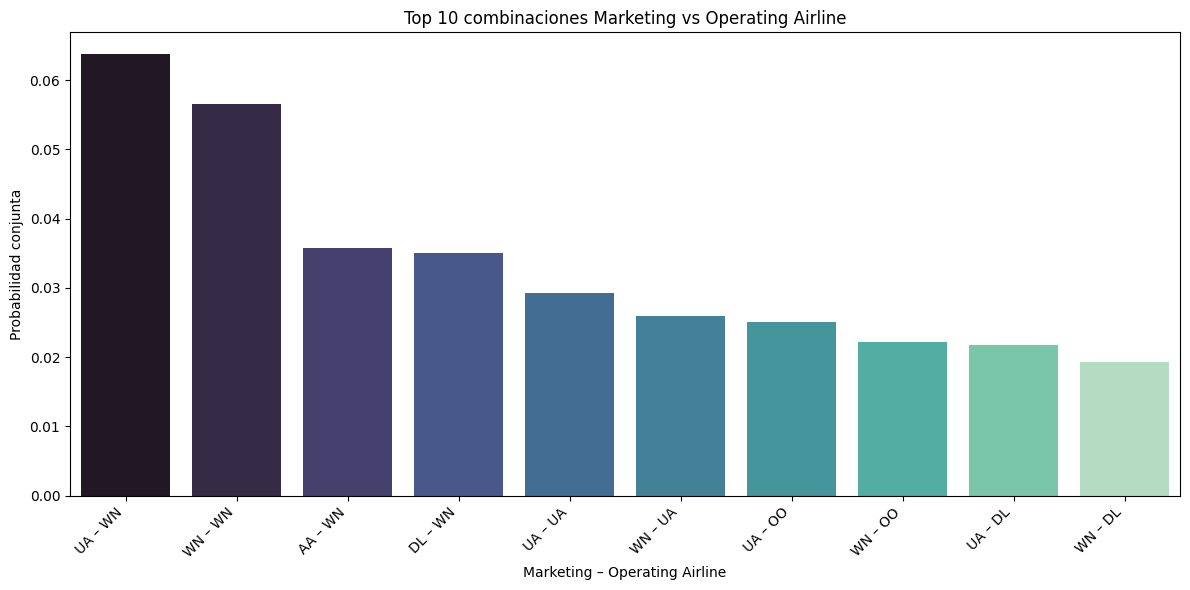

In [42]:
# 1) Convertir a Pandas
ocurrence_0_1_pd = ocurrence_0_1.toPandas()

# 2) Crear una etiqueta combinada
ocurrence_0_1_pd['pair'] = (
    ocurrence_0_1_pd['Marketing_Airline_Network']
    + ' – '
    + ocurrence_0_1_pd['Operating_Airline']
)

# 3) Seleccionar top 10 por probabilidad conjunta
top10 = ocurrence_0_1_pd.nlargest(10, 'ocurrence')

# 4) Graficar con seaborn
plt.figure(figsize=(12,6))
sns.barplot(
    data=top10,
    x='pair',
    y='ocurrence',
    palette='mako'
)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 combinaciones Marketing vs Operating Airline')
plt.xlabel('Marketing – Operating Airline')
plt.ylabel('Probabilidad conjunta')
plt.tight_layout()
plt.show()

In [43]:
ocurrence_0_1.sort(F.desc('ocurrence')).repartition(1).write.mode('overwrite').format('parquet').save(f"./data/flights/{filenames[0][:-4]}_Rule_Marketing_Airline_Network_Operating_Airline")

Ocurrencia entre Dia de la Semana y Mes

- Los dias y meses con mayor ocurrencia de viaje son Lunes, Viernes y Jueves de los meses Octubre, Diciembre y Noviembre

In [44]:
ocurrence_3_4.sort(F.desc('ocurrence')).show()

+---------+-----+--------------------+
|DayOfWeek|Month|           ocurrence|
+---------+-----+--------------------+
|        1|   10|0.017823139999999998|
|        5|   10|           0.0174344|
|        4|   10|          0.01732838|
|        1|   12|0.017263329999999997|
|        3|   10|          0.01705744|
|        1|   11|0.016990989999999997|
|        1|    9|          0.01696073|
|        7|   10|          0.01691608|
|        5|   12|0.016886799999999997|
|        4|   12|          0.01678411|
|        2|   10|          0.01671582|
|        5|   11|           0.0166204|
|        5|    9|           0.0165908|
|        3|   12|          0.01652168|
|        4|   11|0.016519330000000002|
|        4|    9|0.016489910000000003|
|        7|   12|0.016384759999999998|
|        3|   11|          0.01626104|
|        3|    9|0.016232080000000003|
|        2|   12|          0.01619079|
+---------+-----+--------------------+
only showing top 20 rows



/var/folders/83/2c40symn39v1qp_lqrky1mc40000gn/T/ipykernel_93455/1734271371.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


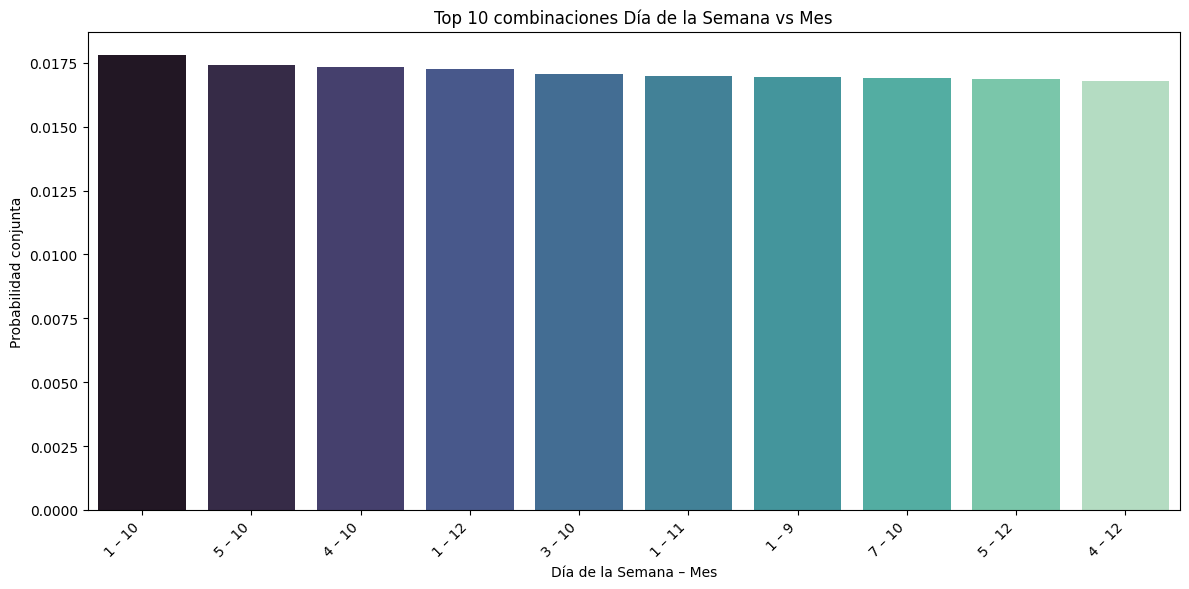

In [45]:
ocurrence_3_4_pd = ocurrence_3_4.toPandas()

# 2) Crear una etiqueta combinada DíaSemana–Mes
ocurrence_3_4_pd['pair'] = (
    ocurrence_3_4_pd['DayOfWeek'].astype(str)
    + ' – '
    + ocurrence_3_4_pd['Month'].astype(str)
)

# 3) Seleccionar top 10 combinaciones por probabilidad conjunta
top10_dw_month = ocurrence_3_4_pd.nlargest(10, 'ocurrence')

# 4) Graficar con seaborn
plt.figure(figsize=(12,6))
sns.barplot(
    data=top10_dw_month,
    x='pair',
    y='ocurrence',
    palette='mako'
)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 combinaciones Día de la Semana vs Mes')
plt.xlabel('Día de la Semana – Mes')
plt.ylabel('Probabilidad conjunta')
plt.tight_layout()
plt.show()

In [46]:
ocurrence_3_4.sort(F.desc('ocurrence')).repartition(1).write.mode('overwrite').format('parquet').save(f"./data/flights/{filenames[0][:-4]}_Rule_DayOfWeek_Month")

Ocurrencia entre Nombre Comercial de la Aerolinea y `DistanceGroup` y 
Los viajes mas tipicos son:
- United Airlines con menos de 1000 millas
- Southwest Airlines con menos de 1000 millas
- United Airlines con menos de 1500 millas

Nota: La variable `DistanceGroup` es un numero entero que representa una agrupacion de cada 500 millas recorridas por el vuelo del avion, es decir si `DistanceGroup = 2` el recorrido seria no mas de 1000 millas

In [47]:
ocurrence_0_5.sort(F.desc('ocurrence')).show()

+-------------------------+-------------+--------------------+
|Marketing_Airline_Network|DistanceGroup|           ocurrence|
+-------------------------+-------------+--------------------+
|                       UA|            2| 0.06815101999999999|
|                       WN|            2| 0.06042333999999999|
|                       UA|            3|0.050590470000000005|
|                       WN|            3|          0.04485399|
|                       UA|            4|          0.04099249|
|                       AA|            2|0.038257099999999995|
|                       UA|            1|0.037694860000000004|
|                       DL|            2|0.037469079999999995|
|                       WN|            4|          0.03634433|
|                       WN|            1|          0.03342062|
|                       AA|            3|          0.02839935|
|                       DL|            3|0.027814380000000003|
|                       UA|            5|0.027533870000

/var/folders/83/2c40symn39v1qp_lqrky1mc40000gn/T/ipykernel_93455/3171629069.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


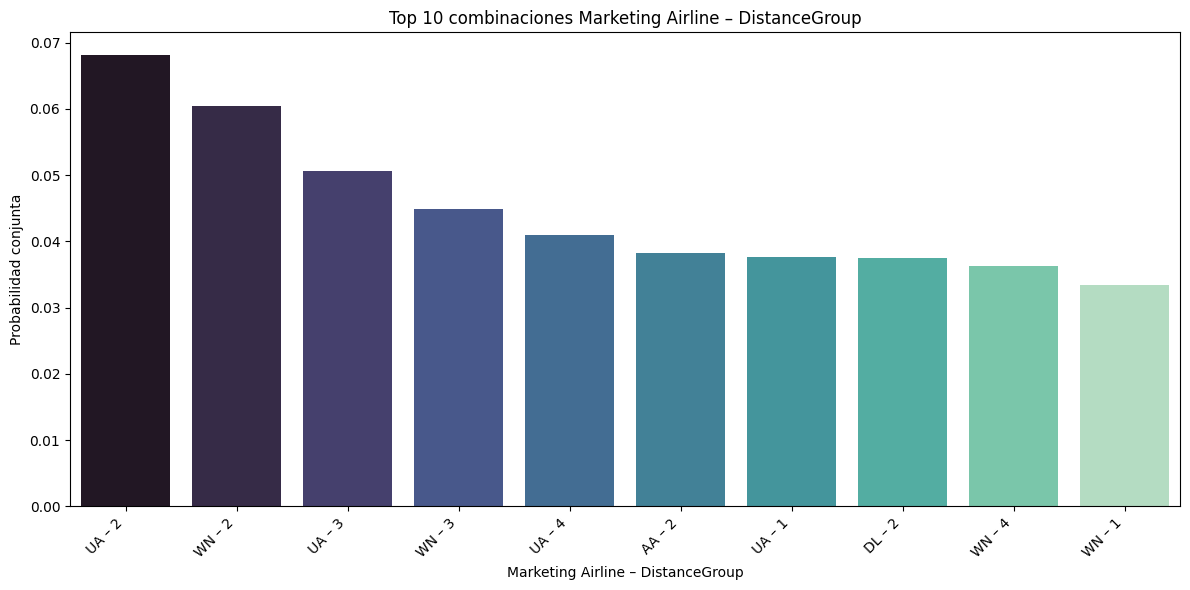

In [50]:
# --- NUEVO: gráfico de barras Marketing_Airline_Network vs DistanceGroup ---
# 1) Convertir a pandas y crear etiqueta combinada
ocurrence_0_5_pd = ocurrence_0_5.toPandas()
ocurrence_0_5_pd['pair'] = (
    ocurrence_0_5_pd['Marketing_Airline_Network']
    + ' – '
    + ocurrence_0_5_pd['DistanceGroup'].astype(str)
)

# 2) Seleccionar top 10 por probabilidad conjunta
top10_md = ocurrence_0_5_pd.nlargest(10, 'ocurrence')

# 3) Graficar
plt.figure(figsize=(12,6))
sns.barplot(
    data=top10_md,
    x='pair',
    y='ocurrence',
    palette='mako'
)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 combinaciones Marketing Airline – DistanceGroup')
plt.xlabel('Marketing Airline – DistanceGroup')
plt.ylabel('Probabilidad conjunta')
plt.tight_layout()
plt.show()

In [51]:
ocurrence_0_5.sort(F.desc('ocurrence')).repartition(1).write.mode('overwrite').format('parquet').save(f"./data/flights/{filenames[0][:-4]}_Rule_Marketing_Airline_Network_DistanceGroup")

Ocurrencia entre Aerolinea y si hubo una desviacion a otro aeropuerto

In [52]:
ocurrence_0_2.sort(F.desc('ocurrence')).show(22)

+-------------------------+--------+--------------------+
|Marketing_Airline_Network|Diverted|           ocurrence|
+-------------------------+--------+--------------------+
|                       UA|   false|          0.26742975|
|                       WN|   false|          0.23710575|
|                       AA|   false|          0.15012375|
|                       DL|   false|           0.1470315|
|                       AS|   false|0.054164250000000004|
|                       B6|   false| 0.05346600000000001|
|                       NK|   false|0.030922500000000002|
|                       F9|   false|0.021047250000000003|
|                       G4|   false|0.016857749999999998|
|                       HA|   false|          0.01625925|
|                       VX|   false|          0.00309225|
|                       UA|    true|6.702500000000001E-4|
|                       WN|    true|           5.9425E-4|
|                       AA|    true|           3.7625E-4|
|             

/var/folders/83/2c40symn39v1qp_lqrky1mc40000gn/T/ipykernel_93455/2467303810.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


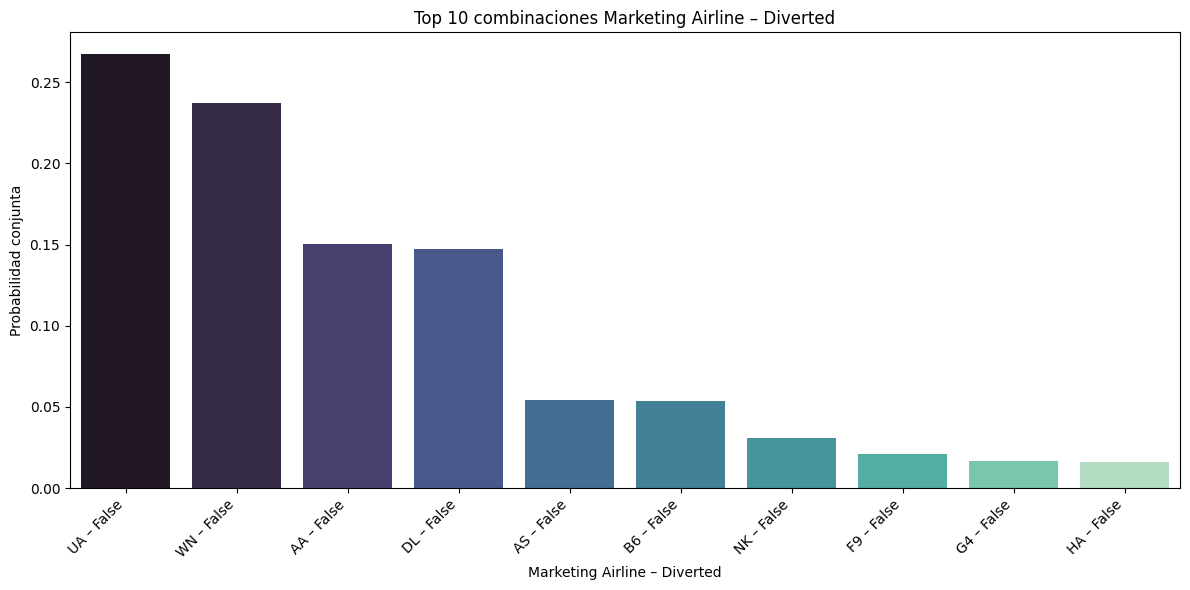

In [53]:
# ——— Nuevo bloque para gráfico de barras ———
# 2) Convertir a pandas y crear etiqueta combinada
ocurrence_0_2_pd = ocurrence_0_2.toPandas()
ocurrence_0_2_pd['pair'] = (
    ocurrence_0_2_pd['Marketing_Airline_Network']
    + ' – '
    + ocurrence_0_2_pd['Diverted'].astype(str)
)

# 3) Seleccionar top 10 combinaciones por probabilidad conjunta
top10_div = ocurrence_0_2_pd.nlargest(10, 'ocurrence')

# 4) Graficar con seaborn
plt.figure(figsize=(12,6))
sns.barplot(
    data=top10_div,
    x='pair',
    y='ocurrence',
    palette='mako'
)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 combinaciones Marketing Airline – Diverted')
plt.xlabel('Marketing Airline – Diverted')
plt.ylabel('Probabilidad conjunta')
plt.tight_layout()
plt.show()

In [54]:
ocurrence_0_2.sort(F.desc('ocurrence')).repartition(1).write.mode('overwrite').format('parquet').save(f"./data/flights/{filenames[0][:-4]}_Rule_Marketing_Airline_Network_Diverted")

Ocurrencia vuelos entre la Aerolinea y el mes

- Los meses mas viajados son en Octubre, Diciembre, Noviembre y Septiembre de la Aerolinea United Airlines
- Los meses mas viajados son en Octubre, Diciembre, Noviembre y Septiembre de la Aerolinea Southwest Airlines

In [55]:
ocurrence_0_4.sort(F.desc('ocurrence')).show()

+-------------------------+-----+--------------------+
|Marketing_Airline_Network|Month|           ocurrence|
+-------------------------+-----+--------------------+
|                       UA|   10|          0.03158218|
|                       UA|   12|          0.03059021|
|                       UA|   11|          0.03010763|
|                       UA|    9|0.030054010000000003|
|                       WN|   10|          0.02800106|
|                       WN|   12|0.027121569999999998|
|                       WN|   11|          0.02669371|
|                       WN|    9|          0.02664617|
|                       UA|    8|          0.02372685|
|                       UA|    4|          0.02276169|
|                       UA|    1|          0.02155524|
|                       WN|    8|0.021036449999999998|
|                       WN|    4|          0.02018073|
|                       WN|    1|          0.01911108|
|                       AA|   10|           0.0177289|
|         

/var/folders/83/2c40symn39v1qp_lqrky1mc40000gn/T/ipykernel_93455/3158421015.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


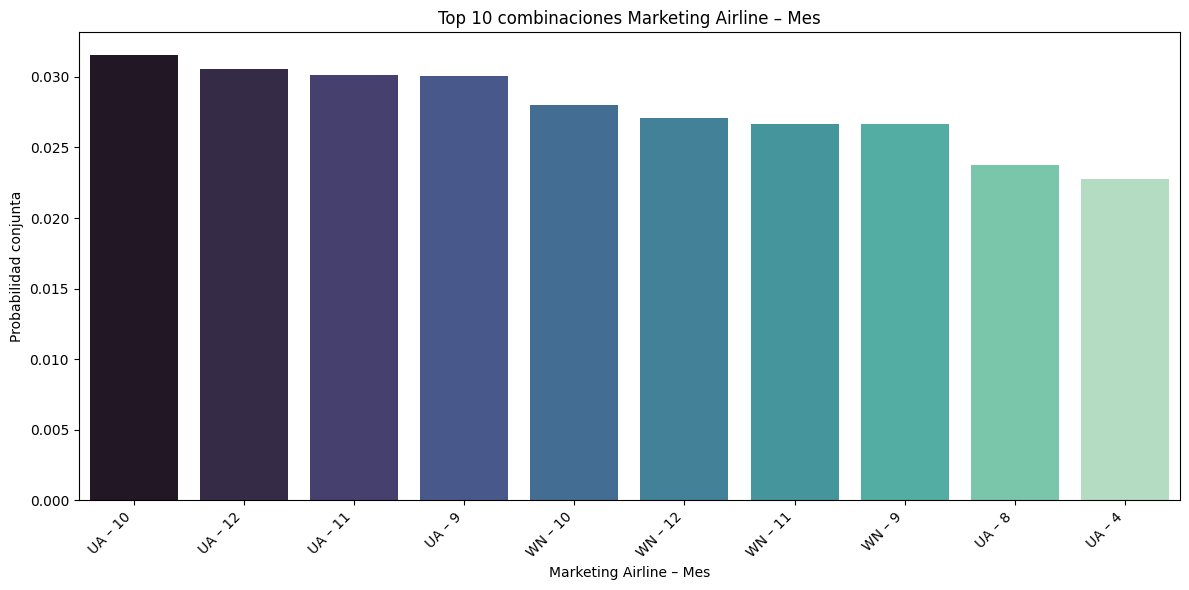

In [56]:
# --- Nuevo bloque: gráfico de barras Marketing vs Mes ---
# 1) Pasar a pandas
ocurrence_0_4_pd = ocurrence_0_4.toPandas()
# 2) Crear etiqueta combinada
ocurrence_0_4_pd['pair'] = (
    ocurrence_0_4_pd['Marketing_Airline_Network']
    + ' – '
    + ocurrence_0_4_pd['Month'].astype(str)
)
# 3) Escoger top 10 prob. conjunta
top10_am = ocurrence_0_4_pd.nlargest(10, 'ocurrence')
# 4) Plot con seaborn
plt.figure(figsize=(12,6))
sns.barplot(
    data=top10_am,
    x='pair',
    y='ocurrence',
    palette='mako'
)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 combinaciones Marketing Airline – Mes')
plt.xlabel('Marketing Airline – Mes')
plt.ylabel('Probabilidad conjunta')
plt.tight_layout()
plt.show()

In [57]:
ocurrence_0_4.sort(F.desc('ocurrence')).repartition(1).write.mode('overwrite').format('parquet').save(f"./data/flights/{filenames[0][:-4]}_Rule_Marketing_Airline_Network_Month")

Ocurrencia de vuelos entre la Aerolinea y el dia de la semana

- Los dias que mas se viaja de la semana son Lunes, Viernes, Jueves para las aerolineas United Airlines y Southwest Airlines

In [58]:
ocurrence_0_3.sort(F.desc('ocurrence')).show()

+-------------------------+---------+--------------------+
|Marketing_Airline_Network|DayOfWeek|           ocurrence|
+-------------------------+---------+--------------------+
|                       UA|        1|          0.04056353|
|                       UA|        5|           0.0396788|
|                       UA|        4|          0.03943751|
|                       UA|        3|          0.03882088|
|                       UA|        7|0.038499160000000004|
|                       UA|        2|          0.03804339|
|                       WN|        1|          0.03596401|
|                       WN|        5|           0.0351796|
|                       WN|        4|0.034965670000000004|
|                       WN|        3|0.034418960000000005|
|                       WN|        7|          0.03413372|
|                       WN|        2|          0.03372963|
|                       UA|        6|          0.03305673|
|                       WN|        6|          0.0293084

/var/folders/83/2c40symn39v1qp_lqrky1mc40000gn/T/ipykernel_93455/1626024890.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


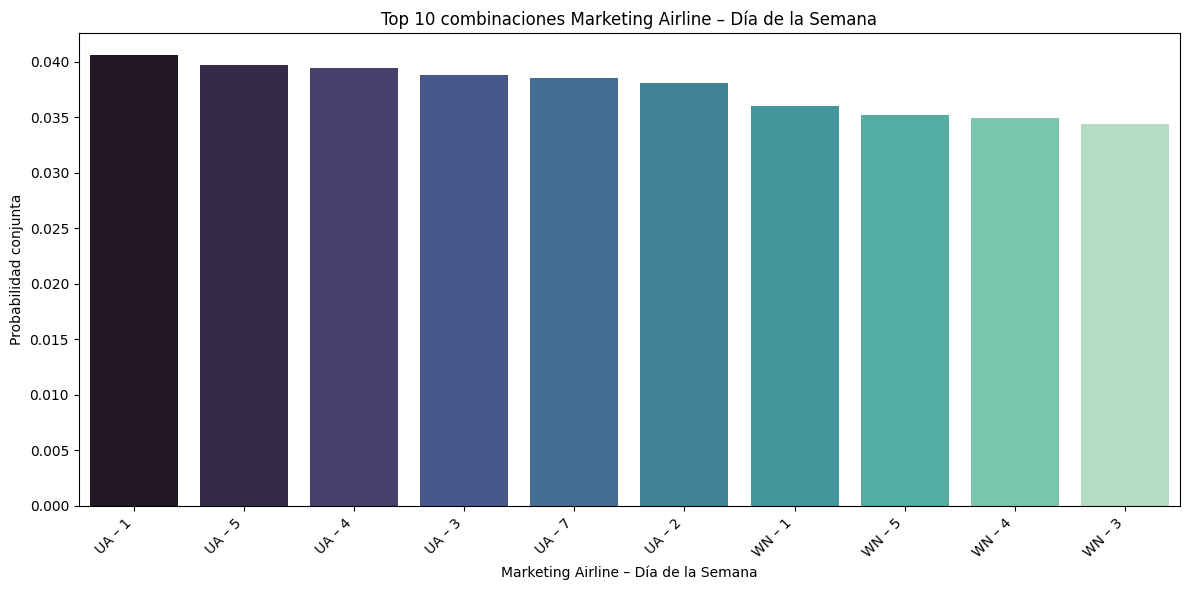

In [59]:
# ——— NUEVO: gráfico de barras Marketing Airline – DayOfWeek ———
# 1) Convertir a pandas
ocurrence_0_3_pd = ocurrence_0_3.toPandas()

# 2) Crear etiqueta combinada Marketing Airline – Día de la Semana
ocurrence_0_3_pd['pair'] = (
    ocurrence_0_3_pd['Marketing_Airline_Network']
    + ' – '
    + ocurrence_0_3_pd['DayOfWeek'].astype(str)
)

# 3) Seleccionar top 10 combinaciones por probabilidad conjunta
top10_md_dw = ocurrence_0_3_pd.nlargest(10, 'ocurrence')

# 4) Graficar con seaborn
plt.figure(figsize=(12,6))
sns.barplot(
    data=top10_md_dw,
    x='pair',
    y='ocurrence',
    palette='mako'
)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 combinaciones Marketing Airline – Día de la Semana')
plt.xlabel('Marketing Airline – Día de la Semana')
plt.ylabel('Probabilidad conjunta')
plt.tight_layout()
plt.show()

In [60]:
ocurrence_0_3.sort(F.desc('ocurrence')).repartition(1).write.mode('overwrite').format('parquet').save(f"./data/flights/{filenames[0][:-4]}_Rule_Marketing_Airline_Network_DayOfWeek")

In [61]:
originCityName = spark.read.parquet(f"{filepath}/{filenames[0][:-4]}_OriginCityName", header=True).withColumnRenamed('frecuencia', f'frecuencia_6').withColumnRenamed('frecuencia_relativa', f'frecuencia_relativa_6')
destCityName = spark.read.parquet(f"{filepath}/{filenames[0][:-4]}_DestCityName", header=True).withColumnRenamed('frecuencia', f'frecuencia_7').withColumnRenamed('frecuencia_relativa', f'frecuencia_relativa_7')

temp_1 = cat_stats[0].crossJoin(originCityName)
temp_2 = cat_stats[0].crossJoin(destCityName)

ocurrence_0_6 = temp_1.withColumn('ocurrence', F.try_multiply(F.col('frecuencia_relativa'), F.col('frecuencia_relativa_6'))).select('Marketing_Airline_Network', 'OriginCityName', 'ocurrence').distinct()
ocurrence_0_7 = temp_2.withColumn('ocurrence', F.try_multiply(F.col('frecuencia_relativa'), F.col('frecuencia_relativa_7'))).select('Marketing_Airline_Network', 'DestCityName', 'ocurrence').distinct()

Ocurrencia entre Aerolinea y la ciudad origen del vuelo

- United Airlines y Southwest Airlines su ciudad origen con mas ocurrencia es Chicago, IL.
- United Airlines su segunda y tercera ciudad origen son Denver, CO y Atlanta, GA.

In [62]:
ocurrence_0_6.sort(F.desc('ocurrence')).show()

+-------------------------+-----------------+--------------------+
|Marketing_Airline_Network|   OriginCityName|           ocurrence|
+-------------------------+-----------------+--------------------+
|                       UA|      Chicago, IL|          0.01764098|
|                       WN|      Chicago, IL|          0.01564066|
|                       UA|       Denver, CO|          0.01187683|
|                       UA|      Atlanta, GA|          0.01053633|
|                       WN|       Denver, CO|0.010530109999999999|
|                       UA|      Houston, TX|          0.01029504|
|                       AA|      Chicago, IL|           0.0099029|
|                       DL|      Chicago, IL|          0.00969892|
|                       WN|      Atlanta, GA|          0.00934161|
|                       WN|      Houston, TX|0.009127679999999999|
|                       UA|     New York, NY|          0.00871325|
|                       UA|  Los Angeles, CA|0.008659630000000

/var/folders/83/2c40symn39v1qp_lqrky1mc40000gn/T/ipykernel_93455/1340999558.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


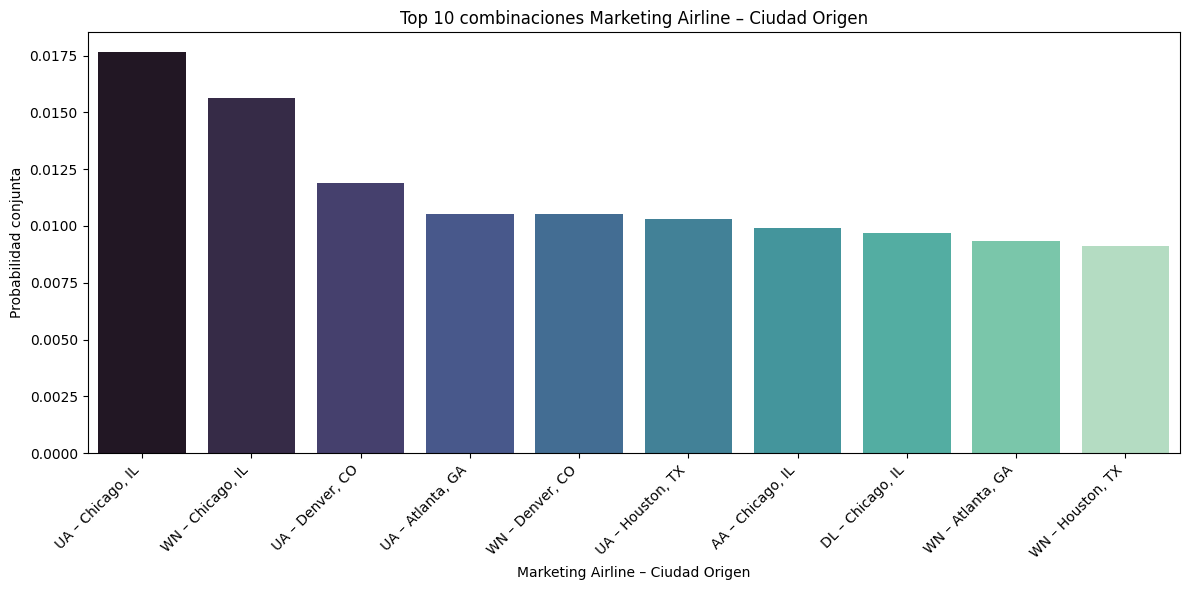

In [63]:
# -- NUEVO BLOQUE: gráfico de barras Marketing Airline – OriginCityName --
# 1) Convertir a pandas y crear etiqueta combinada
ocurrence_0_6_pd = ocurrence_0_6.toPandas()
ocurrence_0_6_pd['pair'] = (
    ocurrence_0_6_pd['Marketing_Airline_Network']
    + ' – '
    + ocurrence_0_6_pd['OriginCityName']
)

# 2) Seleccionar top 10 por probabilidad conjunta
top10_origin = ocurrence_0_6_pd.nlargest(10, 'ocurrence')

# 3) Graficar con seaborn
plt.figure(figsize=(12,6))
sns.barplot(
    data=top10_origin,
    x='pair',
    y='ocurrence',
    palette='mako'
)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 combinaciones Marketing Airline – Ciudad Origen')
plt.xlabel('Marketing Airline – Ciudad Origen')
plt.ylabel('Probabilidad conjunta')
plt.tight_layout()
plt.show()

In [64]:
ocurrence_0_6.sort(F.desc('ocurrence')).repartition(1).write.mode('overwrite').format('parquet').save(f"./data/flights/{filenames[0][:-4]}_Rule_Marketing_Airline_Network_OriginCityName")

Ocurrencia entre la Aerolinea y la ciudad destino en el vuelo

In [65]:
ocurrence_0_7.sort(F.desc('ocurrence')).show()

+-------------------------+-----------------+--------------------+
|Marketing_Airline_Network|     DestCityName|           ocurrence|
+-------------------------+-----------------+--------------------+
|                       UA|      Chicago, IL|          0.01764098|
|                       WN|      Chicago, IL|          0.01564066|
|                       UA|       Denver, CO|          0.01187683|
|                       UA|      Atlanta, GA|          0.01053633|
|                       WN|       Denver, CO|0.010530109999999999|
|                       UA|      Houston, TX|          0.01029504|
|                       AA|      Chicago, IL|           0.0099029|
|                       DL|      Chicago, IL|          0.00969892|
|                       WN|      Atlanta, GA|          0.00934161|
|                       WN|      Houston, TX|0.009127679999999999|
|                       UA|     New York, NY|          0.00871325|
|                       UA|  Los Angeles, CA|0.008659630000000

In [66]:
ocurrence_0_7.sort(F.desc('ocurrence')).repartition(1).write.mode('overwrite').format('parquet').save(f"./data/flights/{filenames[0][:-4]}_Rule_Marketing_Airline_Network_DestCityName")

In [67]:
temp_3 = originCityName.crossJoin(destCityName)
ocurrence_6_7 = temp_3.withColumn('ocurrence', F.try_multiply(F.col('frecuencia_relativa_6'), F.col('frecuencia_relativa_7'))).select('OriginCityName', 'DestCityName', 'ocurrence').distinct().filter(F.col('OriginCityName') != F.col('DestCityName'))

Ocurrencia entre ciudad origen y destino.

- En la tabla se muestran los viajes con mayor probabilidad de ocurrencia siendo Denver a Chicago el de mayor occurencia y de regreso el segundo mayor ocurrencia

In [68]:
ocurrence_6_7.sort(F.desc('ocurrence')).show()

+-----------------+-----------------+--------------------+
|   OriginCityName|     DestCityName|           ocurrence|
+-----------------+-----------------+--------------------+
|       Denver, CO|      Chicago, IL|          0.00291494|
|      Chicago, IL|       Denver, CO|          0.00291494|
|      Chicago, IL|      Atlanta, GA|          0.00258594|
|      Atlanta, GA|      Chicago, IL|          0.00258594|
|      Chicago, IL|      Houston, TX|0.002526719999999...|
|      Houston, TX|      Chicago, IL|0.002526719999999...|
|     New York, NY|      Chicago, IL|0.002138499999999...|
|      Chicago, IL|     New York, NY|0.002138499999999...|
|      Chicago, IL|  Los Angeles, CA|          0.00212534|
|  Los Angeles, CA|      Chicago, IL|          0.00212534|
|   Washington, DC|      Chicago, IL|          0.00198058|
|      Chicago, IL|   Washington, DC|          0.00198058|
|San Francisco, CA|      Chicago, IL|0.001822659999999...|
|      Chicago, IL|San Francisco, CA|0.001822659999999..

/var/folders/83/2c40symn39v1qp_lqrky1mc40000gn/T/ipykernel_93455/3104388968.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


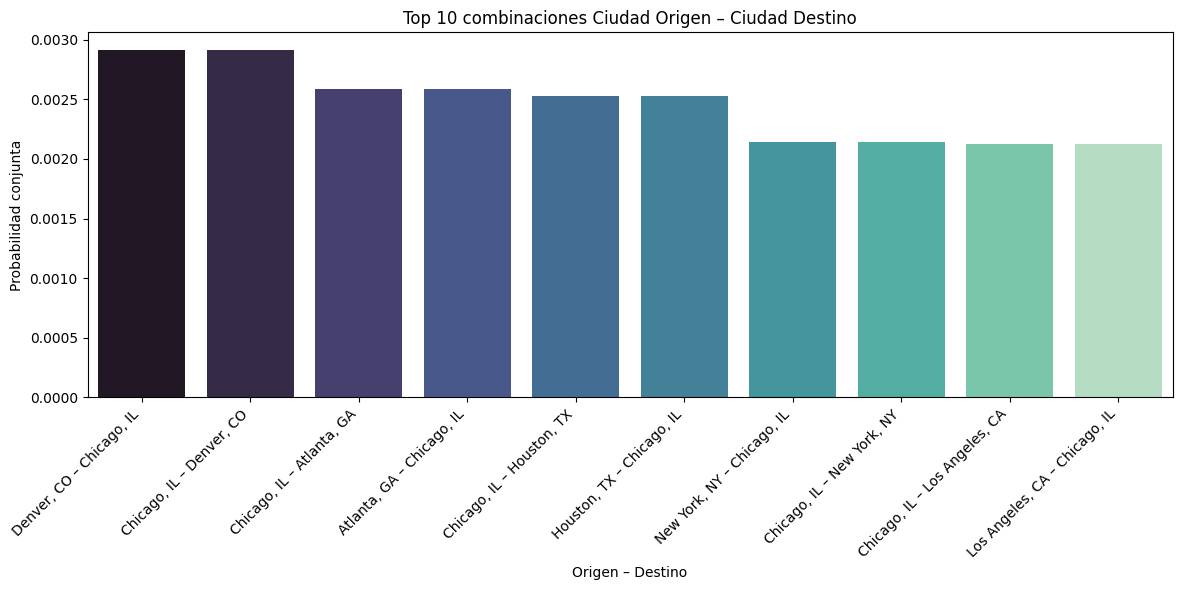

In [69]:
# ——— NUEVO BLOQUE: gráfico de barras OriginCityName – DestCityName ———
# 1) Convertir a pandas y crear etiqueta combinada
ocurrence_6_7_pd = ocurrence_6_7.toPandas()
ocurrence_6_7_pd['pair'] = (
    ocurrence_6_7_pd['OriginCityName']
    + ' – '
    + ocurrence_6_7_pd['DestCityName']
)

# 2) Seleccionar top 10 por probabilidad conjunta
top10_od = ocurrence_6_7_pd.nlargest(10, 'ocurrence')

# 3) Graficar con seaborn
plt.figure(figsize=(12,6))
sns.barplot(
    data=top10_od,
    x='pair',
    y='ocurrence',
    palette='mako'
)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 combinaciones Ciudad Origen – Ciudad Destino')
plt.xlabel('Origen – Destino')
plt.ylabel('Probabilidad conjunta')
plt.tight_layout()
plt.show()

In [70]:
ocurrence_6_7.sort(F.desc('ocurrence')).repartition(1).write.mode('overwrite').format('parquet').save(f"./data/flights/{filenames[0][:-4]}_Rule_OriginCityName_DestCityName")

In [71]:
spark.stop()